In [4]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [55]:
# Cargar el dataset desde train.csv
train_df = pd.read_csv('train.csv')

# Dividir el dataset en entrenamiento y validación
train_ds = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['label'].values))
val_ds = train_ds.take(int(len(train_df) * 0.2))
train_ds = train_ds.skip(int(len(train_df) * 0.2))

# Definir el tamaño del lote y otros parámetros
batch_size = 8
AUTOTUNE = tf.data.AUTOTUNE

# Preparar los datasets para entrenamiento y validación
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Text: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ')

Text: b'Mutual exclusivity?'
Label : 0 
Text: b'Stupid cow, you should enjoy not wearing one before it becomes bloody mandatory in this country.'
Label : 1 
Text: b'Exactly Kevan'
Label : 0 


2024-04-28 18:41:08.895226: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [69]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [70]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [71]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model


In [72]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [73]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


## Define your model


In [78]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [79]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.58637226]], shape=(1, 1), dtype=float32)


## Model training


In [80]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [81]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training


In [83]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [84]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
815/815 [==============================] - 667s 813ms/step - loss: 0.5961 - binary_accuracy: 0.6806 - val_loss: 0.5315 - val_binary_accuracy: 0.7342
Epoch 2/5
815/815 [==============================] - 636s 781ms/step - loss: 0.4568 - binary_accuracy: 0.7805 - val_loss: 0.6182 - val_binary_accuracy: 0.7532
Epoch 3/5
815/815 [==============================] - 632s 776ms/step - loss: 0.3490 - binary_accuracy: 0.8486 - val_loss: 0.7548 - val_binary_accuracy: 0.7600
Epoch 4/5
815/815 [==============================] - 636s 780ms/step - loss: 0.2631 - binary_accuracy: 0.8985 - val_loss: 0.9359 - val_binary_accuracy: 0.7667
Epoch 5/5
815/815 [==============================] - 633s 777ms/step - loss: 0.1986 - binary_accuracy: 0.9310 - val_loss: 1.0108 - val_binary_accuracy: 0.7643


### Evaluate the model


In [85]:
loss, accuracy = classifier_model.evaluate(val_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

204/204 [==============================] - 30s 145ms/step - loss: 1.0108 - binary_accuracy: 0.7643
Loss: 1.0107866525650024
Accuracy: 0.7642725706100464


### Plot the accuracy and loss over time


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


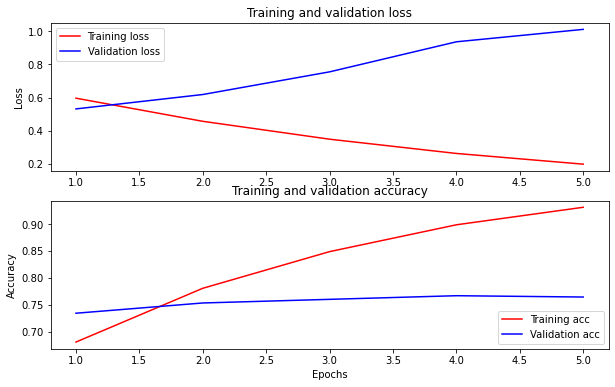

In [86]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [90]:
# Cargar el conjunto de datos test
test_data = pd.read_csv("test_nolabel.csv")

test_data

,text,id
0,Well media selected them exactly because they'...,ce40fcb3a33
1,We must stand together to return this mass of ...,02ca950343c
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05
...,...,...
3488,This political party were neo-nazis in the 90s...,c42316663f5
3489,You're fucking kidding me. I'm stupefied she i...,3e1b52d2030
3490,Instead of caricaturing the whole Muslim and I...,fe66fe0f5cc
3491,"sort out Is , and then they can go back!!!",3a5ca8a8fd5


In [88]:
#Predicción
pred_new = classifier_model.predict(test_data["text"])

# Aplicar umbral para convertir las probabilidades en etiquetas binarias
binary_predictions = (pred_new > 0.5).astype(int)

# Añadir las predicciones binarias al DataFrame
test_data['predicted_label'] = binary_predictions

110/110 [==============================] - 68s 619ms/step


In [89]:
predictions_df = pd.DataFrame({'id': test_data["id"], 'label': test_data['predicted_label']})

predictions_df.to_csv("bert_predictions.csv", index=False, header=True)
predictions_df

,id,label
0,ce40fcb3a33,1
1,02ca950343c,1
2,a59e88b4f9c,0
3,ad62d80af38,0
4,a6b36372f05,0
...,...,...
3488,c42316663f5,1
3489,3e1b52d2030,1
3490,fe66fe0f5cc,1
3491,3a5ca8a8fd5,1
